<a href="https://colab.research.google.com/github/Cammwr/DATA3000/blob/main/Copy_of_CamJuliaProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Packages

In [1]:
#Our foundation libs
import numpy as np
import pandas as pd
import warnings

#Packages for plots
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import matplotlib.ticker as ticker

pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format
warnings.filterwarnings('ignore')

#PACF - ACF(Used to measure correlations across different lengths of time/Shorter lengths of time. )
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#Data modeling
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

#Import Data

In [2]:
#Datasets obtained from Kaggle
holidays = 'holidays_events.csv'
holidays = pd.read_csv(holidays)

oil = 'oil.csv'
oil = pd.read_csv(oil)

stores = 'stores.csv'
stores = pd.read_csv(stores)

transactions = 'transactions.csv'
transactions = pd.read_csv(transactions)

train_data = 'train.csv'
train_data = pd.read_csv(train_data)

test_data = 'test.csv'
test_data = pd.read_csv(test_data)

In [3]:
#View data
holidays.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [4]:
oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [5]:
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [6]:
train_data.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.00,0
1,1,2013-01-01,1,BABY CARE,0.00,0
2,2,2013-01-01,1,BEAUTY,0.00,0
3,3,2013-01-01,1,BEVERAGES,0.00,0
4,4,2013-01-01,1,BOOKS,0.00,0


In [7]:
test_data.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [8]:
transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [9]:
train_data.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.00,0
1,1,2013-01-01,1,BABY CARE,0.00,0
2,2,2013-01-01,1,BEAUTY,0.00,0
3,3,2013-01-01,1,BEVERAGES,0.00,0
4,4,2013-01-01,1,BOOKS,0.00,0


#Data Cleaning and Feature Engineering

In [10]:
#Data cleaining - drop NAs
train_data_cleaned = train_data.dropna()
test_data_cleaned = test_data.dropna()
holidays_cleaned = holidays.dropna()
stores_cleaned = stores.dropna()
oil_cleaned = oil.dropna()
transactions_cleaned = transactions.dropna()

In [11]:
train_data_cleaned

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.00,0
1,1,2013-01-01,1,BABY CARE,0.00,0
2,2,2013-01-01,1,BEAUTY,0.00,0
3,3,2013-01-01,1,BEVERAGES,0.00,0
4,4,2013-01-01,1,BOOKS,0.00,0
...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.13,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.55,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.73,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.00,8


In [12]:
#Feature engineering - weekday, month, season
train_data_cleaned['date'] = pd.to_datetime(train_data_cleaned['date'])
train_data_cleaned['weekday'] = train_data_cleaned['date'].dt.day_name()
train_data_cleaned['month'] = train_data_cleaned['date'].dt.month_name()
train_data_cleaned['year'] = train_data_cleaned['date'].dt.year

def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'
train_data_cleaned['season'] = train_data_cleaned['date'].dt.month.apply(get_season)

#Sales by Year

In [13]:
train_data_cleaned['year'].unique()

array([2013, 2014, 2015, 2016, 2017], dtype=int32)

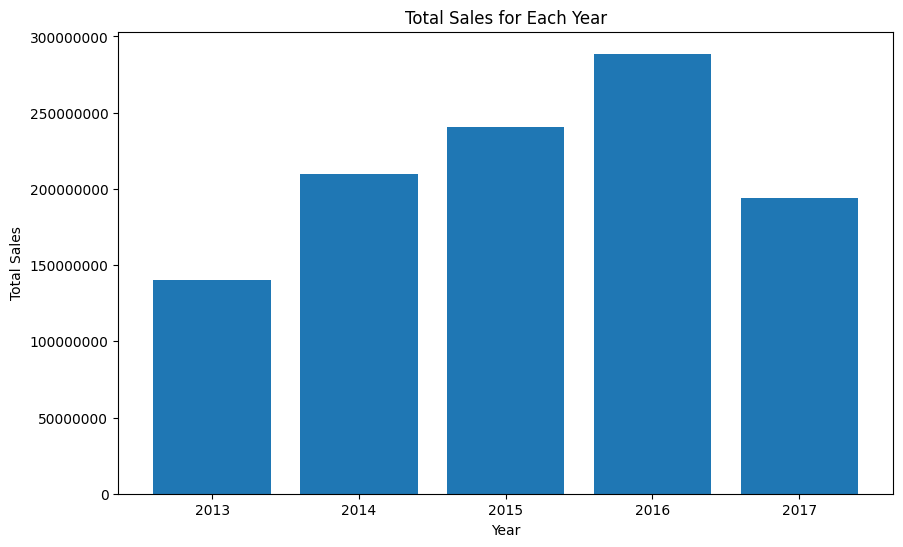

In [14]:
#Total sales per year
total_sales_per_year = train_data_cleaned.groupby('year')['sales'].sum()

plt.figure(figsize=(10, 6))
plt.bar(total_sales_per_year.index, total_sales_per_year.values)
plt.xlabel('Year')
plt.ylabel('Total Sales')
plt.title('Total Sales for Each Year')
plt.ticklabel_format(style='plain', axis='y')
plt.xticks(total_sales_per_year.index, [int(year) for year in total_sales_per_year.index])
plt.show()

#Sales by Season

season
Fall     366.75
Spring   344.38
Summer   355.60
Winter   367.06
Name: sales, dtype: float64


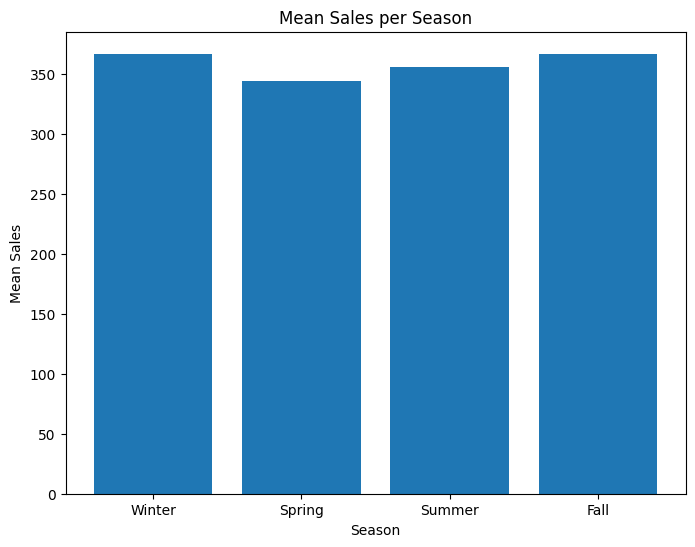

In [15]:
#Sales by season
mean_sales_per_season = train_data_cleaned.groupby('season')['sales'].mean()
print(mean_sales_per_season)
seasons_order = ['Winter', 'Spring', 'Summer', 'Fall']
mean_sales_per_season = mean_sales_per_season.reindex(seasons_order)

plt.figure(figsize=(8, 6))
plt.bar(mean_sales_per_season.index, mean_sales_per_season.values)
plt.xlabel('Season')
plt.ylabel('Mean Sales')
plt.title('Mean Sales per Season')
plt.ticklabel_format(style='plain', axis='y')
plt.show()

#Sales by Month

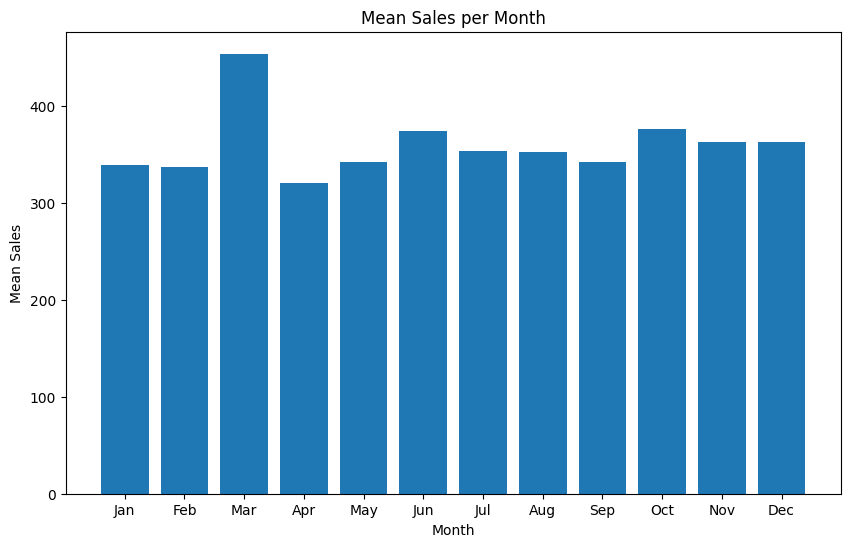

In [16]:
mean_sales_per_month = train_data_cleaned.groupby('month')['sales'].mean()

plt.figure(figsize=(10, 6))
plt.bar(mean_sales_per_month.index, mean_sales_per_month.values)
plt.xlabel('Month')
plt.ylabel('Mean Sales')
plt.title('Mean Sales per Month')
plt.xticks(mean_sales_per_month.index, ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.ticklabel_format(style='plain', axis='y')
plt.show()

In [17]:
#import matplotlib.pyplot as plt
#months_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
#weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sales_pivot = train_data_cleaned.pivot_table(index='weekday', columns='month', values='sales', aggfunc='mean')
#sales_pivot = sales_pivot.reindex(index=weekday_order, columns=months_order)

In [18]:
sales_pivot

month,April,August,December,February,January,July,June,March,May,November,October,September
weekday,,,,,,,,,,,,
Friday,309.07,308.58,425.88,299.16,298.24,348.86,327.08,319.58,308.62,321.24,339.70,322.93
Monday,315.66,342.78,447.70,309.49,345.17,361.42,338.82,323.79,344.05,366.00,341.16,339.28
Saturday,431.53,387.06,497.80,399.25,436.82,456.77,431.77,425.79,414.95,432.39,456.13,446.80
Sunday,449.94,408.70,518.47,390.38,462.42,487.73,457.19,451.42,449.79,511.60,510.57,487.44
Thursday,271.78,265.63,400.34,258.34,256.75,298.12,280.65,289.70,257.57,283.98,280.00,281.22
Tuesday,292.57,319.25,430.92,290.72,299.06,322.69,313.11,309.16,310.36,338.84,296.55,327.17
Wednesday,303.38,320.03,460.28,299.74,300.99,345.25,325.81,340.09,308.52,358.99,320.73,339.64


In [19]:
# Extract year and month from the date
train_data_cleaned['year'] = train_data_cleaned['date'].dt.year
train_data_cleaned['month'] = train_data_cleaned['date'].dt.month

# Group by year and month, calculate total sales, and then calculate mean total sales for each month
mean_total_sales_per_month = train_data_cleaned.groupby(['year', 'month'])['sales'].sum().groupby('month').mean()

print("Mean Total Sales per Month over the Years:")
print(mean_total_sales_per_month)


Mean Total Sales per Month over the Years:
month
1    18888430.46
2    16127445.89
3    19445697.43
4    18133623.51
5    18879827.40
6    18903340.66
7    20672612.14
8    16694475.37
9    19368419.98
10   20020094.79
11   20083947.02
12   24256960.19
Name: sales, dtype: float64


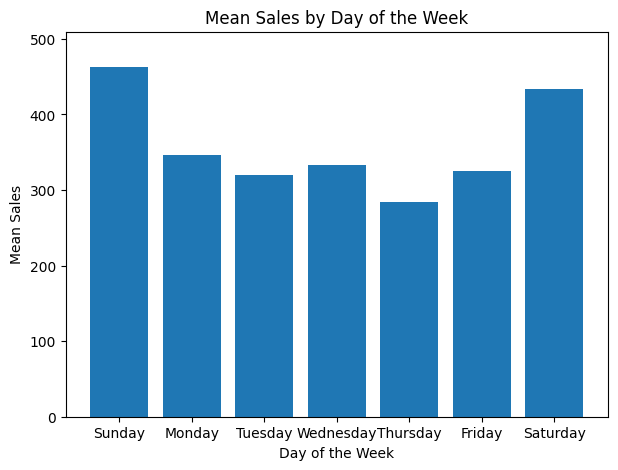

In [20]:
sales_by_day = train_data_cleaned.groupby('weekday')['sales'].mean()

weekdays_order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']

sales_by_day = sales_by_day.reindex(weekdays_order)

plt.figure(figsize=(7, 5))
plt.bar(sales_by_day.index, sales_by_day.values)
plt.xlabel('Day of the Week')
plt.ylabel('Mean Sales')
plt.title('Mean Sales by Day of the Week')
plt.ticklabel_format(style='plain', axis='y')
plt.ylim(0, sales_by_day.max() * 1.1)
plt.show()


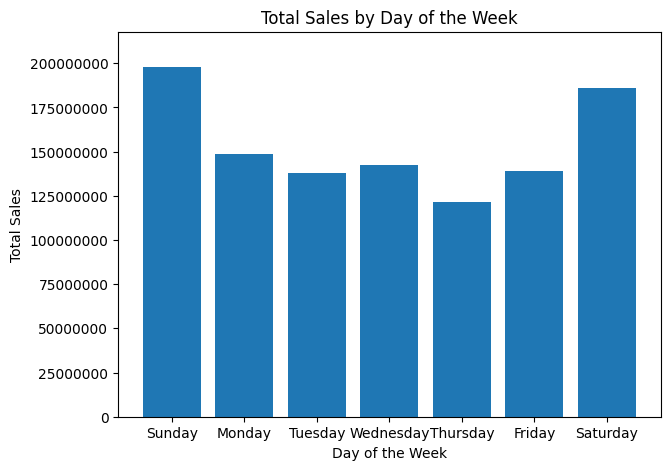

In [21]:
sales_by_day2 = train_data_cleaned.groupby('weekday')['sales'].sum()

weekdays_order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']

sales_by_day2 = sales_by_day2.reindex(weekdays_order)

plt.figure(figsize=(7, 5))
plt.bar(sales_by_day2.index, sales_by_day2.values)
plt.xlabel('Day of the Week')
plt.ylabel('Total Sales')
plt.title('Total Sales by Day of the Week')
plt.ticklabel_format(style='plain', axis='y')
plt.ylim(0, sales_by_day2.max() * 1.1)
plt.show()

#Sales by Month

In [22]:
#Pivot table for average sales per month
average_sales_month_pivot = train_data_cleaned.pivot_table(index='month', values='sales', aggfunc='mean')
print("Average Sales per Month Pivot Table:")
print(average_sales_month_pivot)


Average Sales per Month Pivot Table:
       sales
month       
1     341.92
2     320.93
3     352.01
4     339.20
5     341.77
6     353.60
7     374.22
8     336.99
9     362.30
10    362.41
11    375.68
12    453.74


# Sales by Year

In [23]:
train_data_cleaned['date'] = pd.to_datetime(train_data_cleaned['date'])

# Extract year from the 'date' column
train_data_cleaned['year'] = train_data_cleaned['date'].dt.year

# Group the data by year and sum the sales
sales_by_year = train_data_cleaned.groupby('year')['sales'].sum()

# Print out the sales for each year
print("Total sales for each year:")
print(sales_by_year)

# Calculate the range of sales over the years
sales_range = sales_by_year.max() - sales_by_year.min()

print("\nRange of sales over the years:", sales_range)



Total sales for each year:
year
2013   140419013.92
2014   209474246.30
2015   240880100.65
2016   288654522.95
2017   194217068.37
Name: sales, dtype: float64

Range of sales over the years: 148235509.0342789


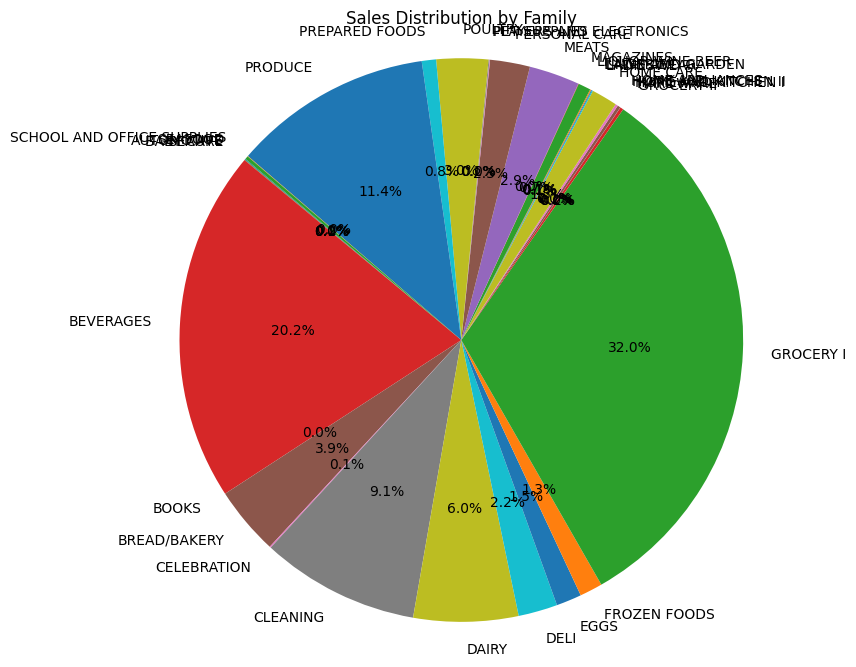

In [24]:

import matplotlib.pyplot as plt

# Assuming train_data_cleaned is your DataFrame with the columns: id, date, store_nbr, family, sales, onpromotion

# Group the data by 'family' and sum the sales
sales_by_family = train_data_cleaned.groupby('family')['sales'].sum()

# Plotting
plt.figure(figsize=(8, 8))  # Set the figure size

# Create the pie chart
plt.pie(sales_by_family, labels=sales_by_family.index, autopct='%1.1f%%', startangle=140, labeldistance=1.1)

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')

# Add a title
plt.title('Sales Distribution by Family')

# Show the plot
plt.show()



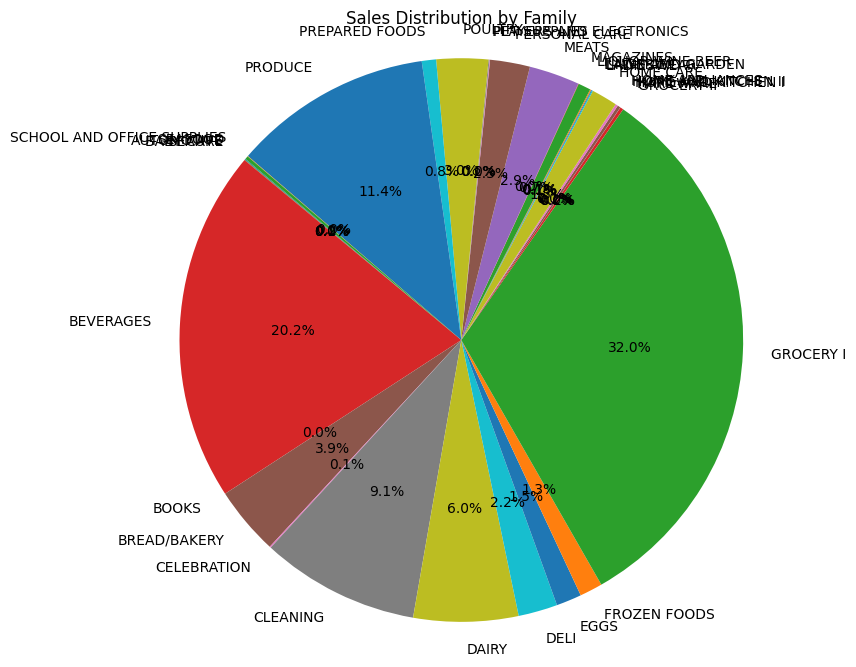

In [25]:

import matplotlib.pyplot as plt

# Assuming sales_by_family is the Series containing total sales for each family

# Filter families with non-zero sales
sales_by_family_nonzero = sales_by_family[sales_by_family > 0]

# Plotting
plt.figure(figsize=(8, 8))
plt.pie(sales_by_family_nonzero, labels=sales_by_family_nonzero.index, autopct='%1.1f%%', startangle=140)

# Set equal aspect ratio for a circular pie chart
plt.axis('equal')

# Add title
plt.title('Sales Distribution by Family')

# Show plot
plt.show()


In [26]:
# Pivot table for average sales
average_sales_pivot = train_data_cleaned.pivot_table(index='family', values='sales', aggfunc='mean')
print("Average Sales Pivot Table:")
print(average_sales_pivot)


Average Sales Pivot Table:
                             sales
family                            
AUTOMOTIVE                    6.10
BABY CARE                     0.11
BEAUTY                        3.72
BEVERAGES                  2385.79
BOOKS                         0.07
BREAD/BAKERY                463.34
CELEBRATION                   8.37
CLEANING                   1072.42
DAIRY                       709.15
DELI                        265.14
EGGS                        171.42
FROZEN FOODS                154.77
GROCERY I                  3776.97
GROCERY II                   21.58
HARDWARE                      1.14
HOME AND KITCHEN I           20.47
HOME AND KITCHEN II          16.72
HOME APPLIANCES               0.46
HOME CARE                   176.20
LADIESWEAR                    7.16
LAWN AND GARDEN               6.04
LINGERIE                      7.18
LIQUOR,WINE,BEER             85.19
MAGAZINES                     2.93
MEATS                       341.85
PERSONAL CARE               

# Data Visulization

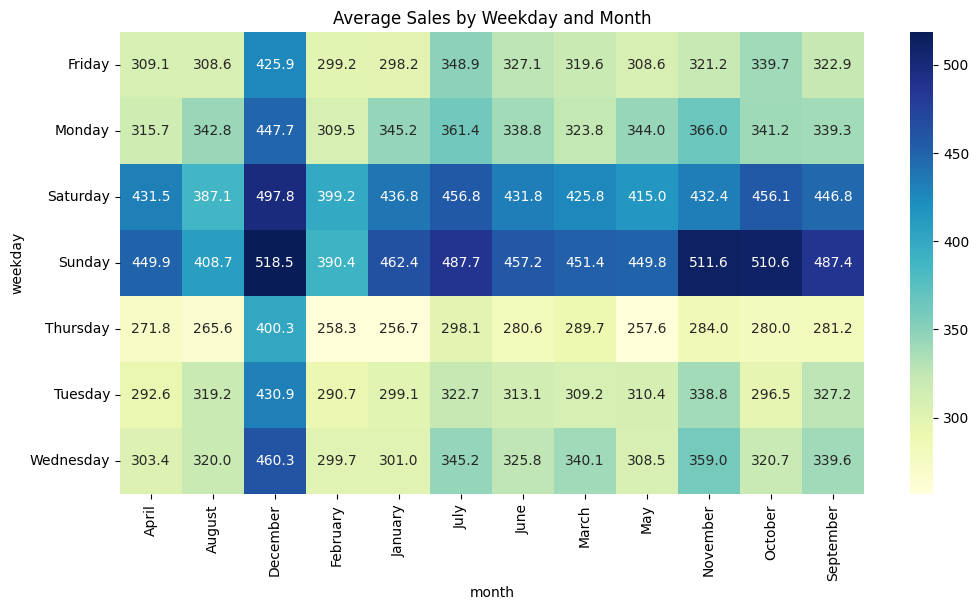

In [27]:
#Heat Map shows the...
plt.figure(figsize=(12, 6))
sns.heatmap(sales_pivot, cmap='YlGnBu', annot=True, fmt=".1f")
plt.title('Average Sales by Weekday and Month')
plt.show()

In [28]:
train_data_cleaned

,id,date,store_nbr,family,sales,onpromotion,weekday,month,year,season
0,0,2013-01-01,1,AUTOMOTIVE,0.00,0,Tuesday,1,2013,Winter
1,1,2013-01-01,1,BABY CARE,0.00,0,Tuesday,1,2013,Winter
2,2,2013-01-01,1,BEAUTY,0.00,0,Tuesday,1,2013,Winter
3,3,2013-01-01,1,BEVERAGES,0.00,0,Tuesday,1,2013,Winter
4,4,2013-01-01,1,BOOKS,0.00,0,Tuesday,1,2013,Winter
...,...,...,...,...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.13,0,Tuesday,8,2017,Summer
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.55,1,Tuesday,8,2017,Summer
3000885,3000885,2017-08-15,9,PRODUCE,2419.73,148,Tuesday,8,2017,Summer
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.00,8,Tuesday,8,2017,Summer


In [29]:
train_data_cleaned['weekday'] = train_data_cleaned['date'].dt.dayofweek  # Monday=0, Sunday=6
train_data_cleaned['month'] = train_data_cleaned['date'].dt.month
train_data_cleaned['year'] = train_data_cleaned['date'].dt.year


## It's Mighty Model Time | *(ben10...)*

In [30]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from numpy import absolute
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [31]:
X = train_data_cleaned[['date']]
y = train_data_cleaned['sales']

In [32]:
split_date = '2017-01-01'  # Specify the split date

# Convert split date to datetime format
split_date = pd.to_datetime(split_date)


train_data_cleaned.index = pd.to_datetime(train_data_cleaned.index)
# Split the data into training and testing sets
train_dates = train_data_cleaned.index
train_data = train_data_cleaned[train_dates <= split_date]
test_data = train_data_cleaned[train_dates > split_date]


#

# Check the size of the training and testing sets
print("Training data size:", len(train_data))
print("Testing data size:", len(test_data))

Training data size: 3000888
Testing data size: 0


In [101]:
#make sure to split the data or try to so our model will run (NOTE)

In [33]:
data_encoded = pd.get_dummies(train_data_cleaned, columns=['date'], )
#model = XGBRegressor(n_estimators=100, learning_rate=0.05, objective='reg:squarederror',)
#model.fit(X_train,y_train)

In [34]:
train_data_cleaned

,id,date,store_nbr,family,sales,onpromotion,weekday,month,year,season
1970-01-01 00:00:00.000000000,0,2013-01-01,1,AUTOMOTIVE,0.00,0,1,1,2013,Winter
1970-01-01 00:00:00.000000001,1,2013-01-01,1,BABY CARE,0.00,0,1,1,2013,Winter
1970-01-01 00:00:00.000000002,2,2013-01-01,1,BEAUTY,0.00,0,1,1,2013,Winter
1970-01-01 00:00:00.000000003,3,2013-01-01,1,BEVERAGES,0.00,0,1,1,2013,Winter
1970-01-01 00:00:00.000000004,4,2013-01-01,1,BOOKS,0.00,0,1,1,2013,Winter
...,...,...,...,...,...,...,...,...,...,...
1970-01-01 00:00:00.003000883,3000883,2017-08-15,9,POULTRY,438.13,0,1,8,2017,Summer
1970-01-01 00:00:00.003000884,3000884,2017-08-15,9,PREPARED FOODS,154.55,1,1,8,2017,Summer
1970-01-01 00:00:00.003000885,3000885,2017-08-15,9,PRODUCE,2419.73,148,1,8,2017,Summer
1970-01-01 00:00:00.003000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.00,8,1,8,2017,Summer


In [35]:
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

# Assuming 'train_data_cleaned' is your DataFrame with the sales data

# Convert the date column to datetime format
#train_data_cleaned['date'] = pd.to_datetime(train_data_cleaned['date'])

# Set the date column as the index
train_data_cleaned.set_index('date', inplace=True)

# Resample the data to a daily frequency (if it's not already in that frequency)
train_data_cleaned = train_data_cleaned.resample('D').sum()

# Fill in any missing values or gaps in the data (if necessary)
train_data_cleaned.fillna(method='ffill', inplace=True)  # Forward fill missing values

# Fit the ARIMA model
model = ARIMA(train_data_cleaned['sales'], order=(7,1,0))  # Example order, you can tune this
model_fit = model.fit()




In [36]:
forecast = model_fit.forecast(steps=209)

In [37]:
# Print the forecasted values
print("Forecasted Sales:")
print(forecast)

Forecasted Sales:
2017-08-16   747729.68
2017-08-17   702736.82
2017-08-18   800271.76
2017-08-19   801420.15
2017-08-20   830560.46
                ...   
2018-03-08   775372.74
2018-03-09   775376.87
2018-03-10   775379.40
2018-03-11   775379.44
2018-03-12   775377.61
Freq: D, Name: predicted_mean, Length: 209, dtype: float64


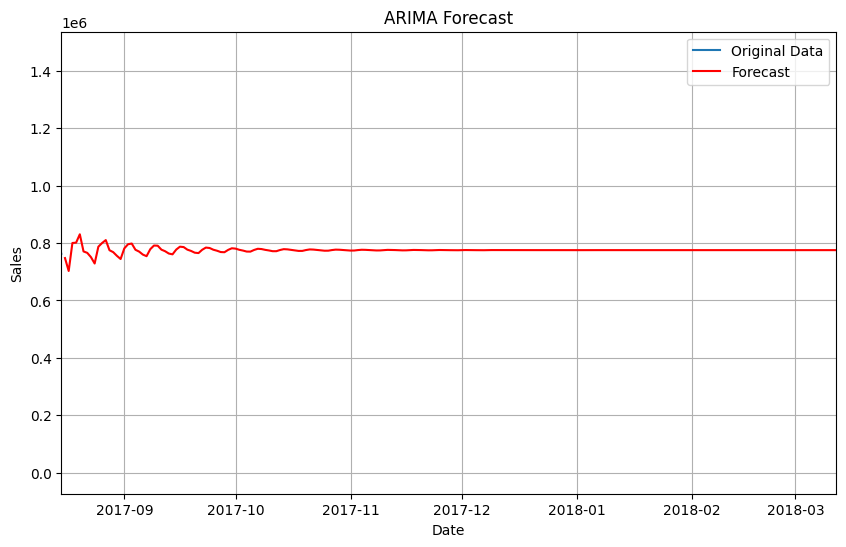

In [38]:
# Assuming train_data_cleaned is your DataFrame with a datetime index and 'sales' column

# Plot the original sales data
plt.figure(figsize=(10, 6))
plt.plot(train_data_cleaned.index, train_data_cleaned['sales'], label='Original Data')

# Plot the forecasted values with aligned dates
forecast_index = pd.date_range(start=train_data_cleaned.index[-1] + pd.Timedelta(days=1), periods=len(forecast))
plt.plot(forecast_index, forecast, color='red', label='Forecast')

plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('ARIMA Forecast')
plt.legend()
plt.grid(True)

# Set x-axis limits to start from where the original data ends
plt.xlim(train_data_cleaned.index[-1], forecast_index[-1])

plt.show()


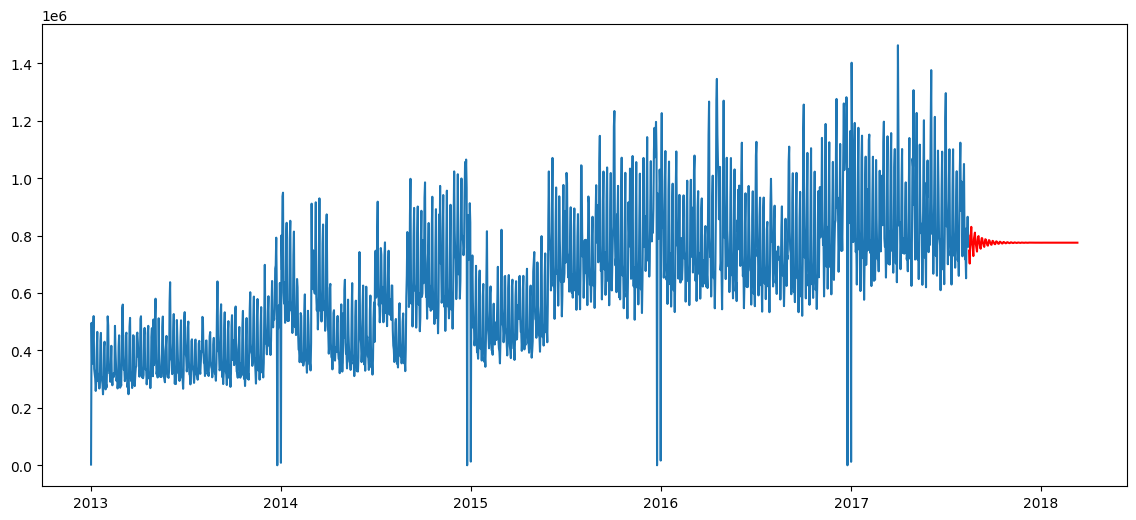

In [39]:
# Plot the original sales data
plt.figure(figsize=(14, 6))
plt.plot(train_data_cleaned.index, train_data_cleaned['sales'], label='Original Data')

# Plot the forecasted values with aligned dates
forecast_index = pd.date_range(start=train_data_cleaned.index[-1] + pd.Timedelta(days=1), periods=len(forecast))
plt.plot(forecast_index, forecast, color='red', label='Forecast')






In [40]:
forecast

2017-08-16   747729.68
2017-08-17   702736.82
2017-08-18   800271.76
2017-08-19   801420.15
2017-08-20   830560.46
                ...   
2018-03-08   775372.74
2018-03-09   775376.87
2018-03-10   775379.40
2018-03-11   775379.44
2018-03-12   775377.61
Freq: D, Name: predicted_mean, Length: 209, dtype: float64